In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from collections import namedtuple
import arviz as az


plt.rcParams['figure.figsize'] = (15, 10)


In [2]:
data = pd.read_csv("moscow.csv", sep=";").rename(columns={
    "Заражений за день": "Infected",
    "Выздоровлений за день": "Recovered"
})
data["timestamp"] = pd.to_datetime(data["Дата"], format="%d.%m.%Y")
data = data.sort_values(by="timestamp")
data = data.set_index("timestamp")

In [3]:
wave = namedtuple("wave", ["start", "end"])

In [4]:
waves = [ 
    wave("2020-03-20", "2020-07-05"),
    wave("2020-09-20", "2021-02-10"),
    wave("2021-04-01", "2021-08-30"),
    wave("2021-09-05", "2021-11-30"),
    wave("2022-01-02", "2022-02-20")
]

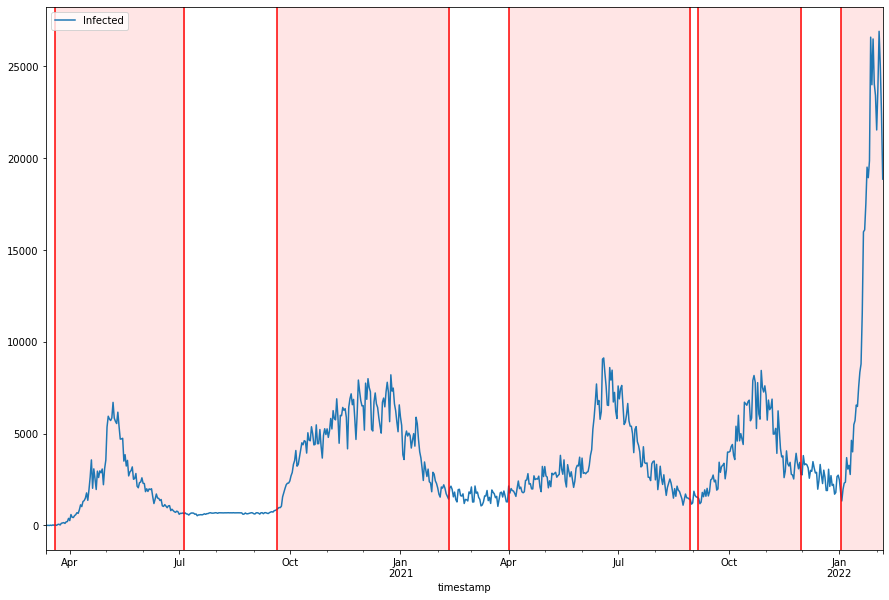

In [5]:
ax = data[["Infected"]].resample("1D").sum().plot()
for _wave in waves:
    ax.axvline(_wave.start, color="r")
    ax.axvline(_wave.end, color="r")
    ax.axvspan(_wave.start, _wave.end, color="r", alpha=0.1)

In [6]:
coef = 10_000_000
data["NormInfected"] = data["Infected"] / coef
data["NormRecovered"] = data["Recovered"] / coef

In [7]:
import pymc3 as pm
import theano
from pymc3.ode import DifferentialEquation

### SIR
$$ \frac{dS}{dt}  =  -\frac{\beta I S}{N}$$
$$ \frac{dI}{dt}  =  \frac{\beta I S}{N} - \gamma I $$
$$ \frac{dR}{dt}  = \gamma I $$

$$ S + I + R = N $$ 
In  general N(t) too

In [96]:
def sir(y, t, p, n=1):
    s, i, r = y[0], y[1], y[2]
    beta, gamma = p[0], p[1]
    return (
        - beta * i * s / n,
        beta * i * s / n - gamma * i,
        gamma * i
    )

In [97]:
times = np.arange(0, 400, 1)
y0 = (1, 0.001, 0)

beta, gamma = 0.01, 1 / 14
y = odeint(sir, t=times, y0=y0, args=tuple([[beta, gamma]]))


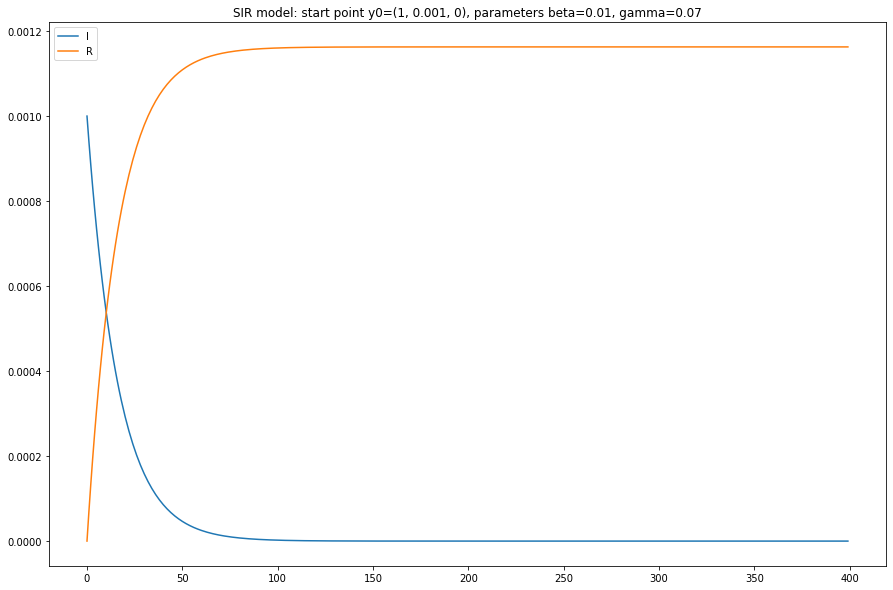

In [98]:
variables = ("S", "I", "R")
for i, _label in enumerate(variables):
    if _label == "S":
        continue
    _ = plt.plot(y[:, i], label=_label)

plt.title(f"SIR model: start point {y0=}, parameters {beta=:0.2f}, {gamma=:0.2f}")
_ = plt.legend()

In [99]:
def create_sir_model(df_slice: pd.Series):
    global sir
    model = DifferentialEquation(
        func=sir,
        times=np.arange(1, len(df_slice), 1),
        n_states=3,
        n_theta=2,
    )
    return model

In [160]:
first_wave = data[waves[0].start:waves[0].end]

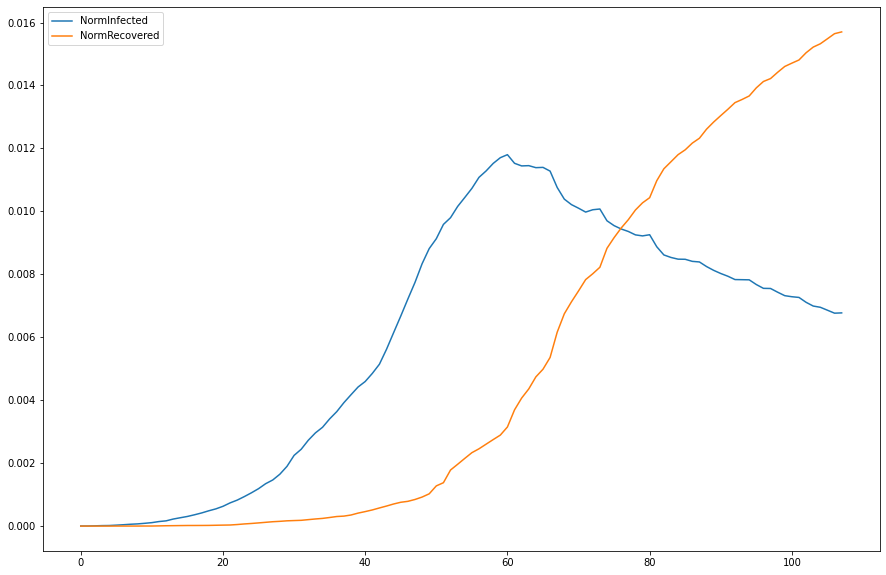

In [161]:
_wave = first_wave[["NormInfected", "NormRecovered"]].cumsum()
_wave["NormInfected"] = _wave["NormInfected"] - _wave["NormRecovered"]
_ = _wave[["NormInfected", "NormRecovered"]].reset_index(drop=True).plot()

In [162]:
sir_ode = create_sir_model(_wave)
with pm.Model() as m:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    beta = pm.Lognormal("beta", np.log(0.5), 1)
    gamma = pm.Lognormal("gamma", np.log(0.5), 1)

    NormRecovered = _wave.iloc[0].NormRecovered
    NormInfected = _wave.iloc[0].NormInfected

    curves = sir_ode(y0=[1 - NormInfected - NormRecovered, NormInfected, NormRecovered], theta=[beta, gamma])
    Y = pm.Lognormal(
        "Y", mu=pm.math.log(curves[:, (1, 2)].clip(1e-07, 1e8)),
        sigma=sigma, observed=_wave[["NormInfected", "NormRecovered"]].values[1:].clip(1e-07)
    )

In [140]:
with m:
    trace = pm.sample(1000)

/tmp/ipykernel_6484/2692056478.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, beta, sigma]


/home/marti/.pyenv/versions/3.8.5/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/marti/.pyenv/versions/3.8.5/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3760 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [124]:
with m:
    samples = trace.sample(1000)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marti/.pyenv/versions/3.8.5/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'sigma\n0'}>,
       <AxesSubplot:title={'center':'sigma\n1'}>,
       <AxesSubplot:title={'center':'beta'}>,
       <AxesSubplot:title={'center':'gamma'}>], dtype=object)

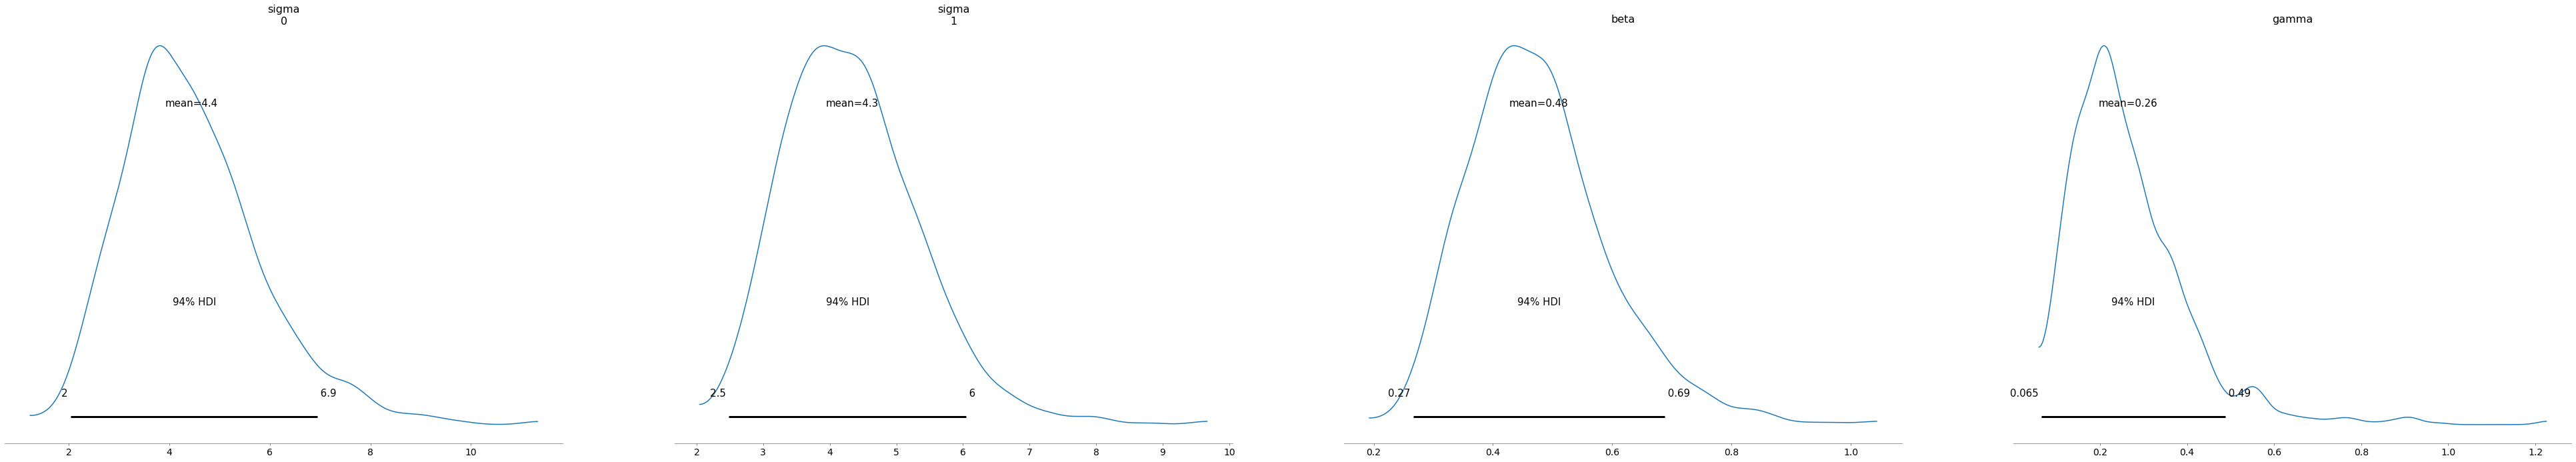

In [141]:
az.plot_posterior(samples)


In [163]:
with m:
    map_estimate = pm.find_MAP(model=m)


In [164]:
map_estimate

{'sigma_log__': array([ 0.95839222, -0.23751336]),
 'beta_log__': array(-1.20296584),
 'gamma_log__': array(-1.57015335),
 'sigma': array([2.6075008 , 0.78858636]),
 'beta': array(0.30030224),
 'gamma': array(0.20801328)}

In [187]:
times = np.arange(0, len(_wave), 1)
NormRecovered = _wave.iloc[0].NormRecovered
NormInfected = _wave.iloc[0].NormInfected
y0 = (1 - NormInfected - NormRecovered, NormInfected, NormRecovered)

beta, gamma = map_estimate["beta"].item(), map_estimate["gamma"].item()
beta, gamma = 0.5, 0.01

y = odeint(sir, t=times, y0=y0, args=tuple([[beta, gamma]]))


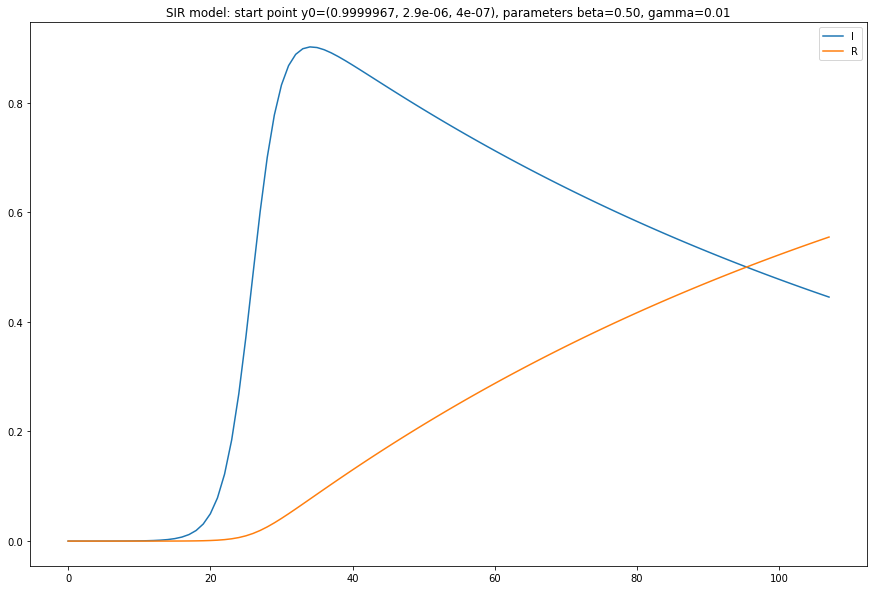

In [188]:
variables = ("S", "I", "R")
for i, _label in enumerate(variables):
    if _label == "S":
        continue
    _ = plt.plot(y[:, i], label=_label)

plt.title(f"SIR model: start point {y0=}, parameters {beta=:0.2f}, {gamma=:0.2f}")
_ = plt.legend()